# 概要
電力消費量データの分析を通して、ハンズオンで様々な知見を得ることを目標とした勉強ノート

礎知識がないので、ランダムウォークしています



#### 参考URL
- [Gonosyデータ分析ブログ](https://data.gunosy.io/entry/statsmodel_trend)
- [tokei.net](https://to-kei.net/time-series-analysis/time-series-analysis-mamodel/)
- [電力データセット](http://www.tepco.co.jp/forecast/index-j.html)
- [祝日データセット](http://www8.cao.go.jp/chosei/shukujitsu/syukujitsu_kyujitsu.csv)
- [Logics of Blue](https://logics-of-blue.com/time-series-regression/)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import urllib
import io
import statsmodels.api as sm
#from IPython.core.debugger import Pdb; Pdb().set_trace()
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 10,5

In [2]:
res = urllib.request.urlopen("http://www.tepco.co.jp/forecast/html/images/juyo-2018.csv")
res=res.read().decode('shift-jis').splitlines(keepends=True)
startPoint = 0

for line in res:
    if line.count(',') != 0: #カンマがあればテーブル構造と判断
        startPoint += 1
        break
    if startPoint != 0:
        break
    
res[startPoint:]
row_data = pd.read_csv(io.StringIO(''.join(res[startPoint:])))
row_data.head()

,DATE,TIME,実績(万kW)
0,2018/1/1,0:00,2962
1,2018/1/1,1:00,2797
2,2018/1/1,2:00,2669
3,2018/1/1,3:00,2586
4,2018/1/1,4:00,2543


In [3]:
daily_data = row_data.groupby('DATE')['実績(万kW)'].sum().reset_index() #元データが1時間ごとなので日毎のデータにする
daily_data = daily_data.set_index(['DATE'])

夏と冬が電力消費多め。エアコンの影響？1日の電力消費が安定していないのは休日や気温の影響？

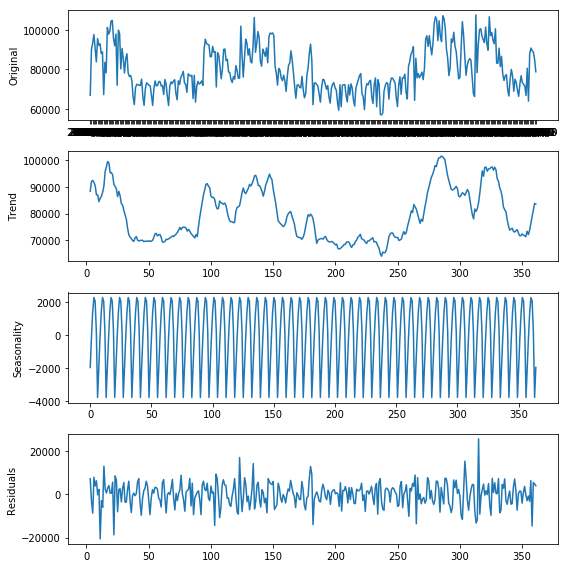

In [4]:
res = sm.tsa.seasonal_decompose(daily_data.values, freq=7)
#res.plot()
plt.figure(figsize=(8, 8)) # グラフ描画枠作成、サイズ指定

# オリジナルデータのプロット
plt.subplot(411) # グラフ4行1列の1番目の位置（一番上）
plt.plot(daily_data)
plt.ylabel('Original')

# trend データのプロット
plt.subplot(412) # グラフ4行1列の2番目の位置
plt.plot(res.trend)
plt.ylabel('Trend')

# seasonalデータ のプロット
plt.subplot(413) # グラフ4行1列の3番目の位置
plt.plot(res.seasonal)
plt.ylabel('Seasonality')

# residual データのプロット
plt.subplot(414) # グラフ4行1列の4番目の位置（一番下）
plt.plot(res.resid)
plt.ylabel('Residuals')

plt.tight_layout() # グラフの間隔を自動調整

プロット図は上から観測データ(生データ)、トレンド成分、季節成分、残差を表す。
観測データ(生データ) = トレンド成分 + 季節成分 + 残差 が成り立つ。

--------------------------------------------
##### 言葉の定義
トレンド成分・・・一定の増加傾向、あるいは減少傾向のような、長期に渡るデータの傾向。水平パターンもトレンドの一つ。

季節成分・・・四季、雨季・乾季、月・週などによって、一定の間隔で繰り返される波動要因

季節成分が、トレンドと加法的または乗法的な関係を持つ場合を考えます。

残差・・・観測値と予測値の差


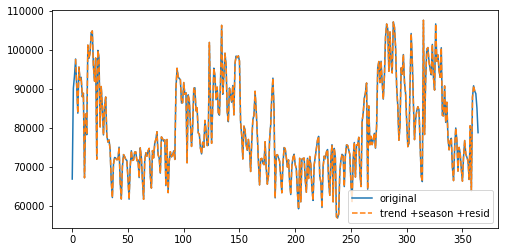

In [5]:
sum_three_data = res.trend + res.seasonal + res.resid # トレンド + 季節性 + 残差
plt.figure(figsize=(8, 4)) # グラフ描画枠作成、サイズ指定
plt.plot(daily_data.values, label='original')
plt.plot(sum_three_data, label='trend +season +resid', linestyle='--')
plt.legend(loc='best') # 凡例表示

トレンド + 季節性 + 残差を元データと比較。

観測データ＝トレンド + 季節性 + 残差

は成り立っていそう。

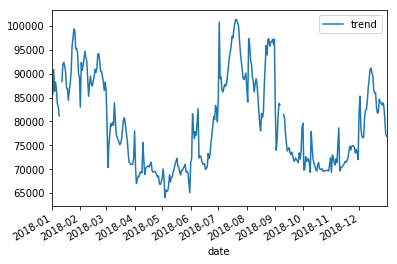

In [6]:
trend = res.trend
trend = pd.DataFrame({'trend': trend, 'date':daily_data.index})
trend['date'] = pd.to_datetime(trend['date'], format='%Y-%m-%d')
trend = trend.set_index(['date'])
trend = trend.plot()

季節成分を見ると、夏と冬は電力消費量が大きい

In [7]:
seasonal_data = res.seasonal
seasonal = pd.DataFrame({'seasonal': seasonal_data, 'date':daily_data.index})
seasonal['date'] = pd.to_datetime(seasonal['date'], format='%Y-%m-%d')
seasonal['weekday'] = seasonal['date'].dt.dayofweek
seasonal.groupby('weekday').mean()

,seasonal
weekday,
0,-45.030004
1,889.961141
2,1275.690265
3,721.335315
4,-148.311177
5,-1337.299326
6,-1393.054808


曜日別の電力消費量を見てみる

電力消費は　日≒土＜＜＜金＜月＜＜＜木＜火＜水　と次第に増えていく。会社の稼働日が影響している？
祝日データも結合して、もう少し見てみる。

In [8]:
res = urllib.request.urlopen("http://www8.cao.go.jp/chosei/shukujitsu/syukujitsu_kyujitsu.csv")
res=res.read().decode('shift-jis')
df = pd.read_csv(io.StringIO(res))
df.head()

,国民の祝日・休日月日,国民の祝日・休日名称
0,2017-01-01,元日
1,2017-01-02,休日
2,2017-01-09,成人の日
3,2017-02-11,建国記念の日
4,2017-03-20,春分の日


In [9]:
df['国民の祝日・休日月日'].astype(str)
df['国民の祝日・休日月日'] = pd.to_datetime(df['国民の祝日・休日月日'], format='%Y-%m-%d')
df[10:20]

,国民の祝日・休日月日,国民の祝日・休日名称
10,2017-08-11,山の日
11,2017-09-18,敬老の日
12,2017-09-23,秋分の日
13,2017-10-09,体育の日
14,2017-11-03,文化の日
15,2017-11-23,勤労感謝の日
16,2017-12-23,天皇誕生日
17,2018-01-01,元日
18,2018-01-08,成人の日
19,2018-02-11,建国記念の日


In [10]:
df = df.rename(columns={'国民の祝日・休日月日': 'date'})
seasonal=seasonal.reset_index()
seasonal['date'].astype(str)
seasonal['date'] = pd.to_datetime(seasonal['date'], format='%Y-%m-%d')
merge = pd.merge(seasonal,df,how='left',on='date')

In [11]:
merge.weekday = merge.weekday.where(merge['国民の祝日・休日名称'].isnull(), 7)
merge.groupby('weekday').count()

,index,seasonal,date,国民の祝日・休日名称
weekday,,,,
0,44,44,44,0
1,52,52,52,0
2,51,51,51,0
3,51,51,51,0
4,50,50,50,0
5,49,49,49,0
6,48,48,48,0
7,20,20,20,20


マージはうまく出来ていそう。

In [12]:
merge.groupby('weekday').mean()

,index,seasonal
weekday,,
0,179.181818,0.867032
1,179.173077,889.961141
2,180.117647,1256.443219
3,181.882353,691.218563
4,185.400000,-39.951296
5,183.224490,-1343.237730
6,185.250000,-1378.039529
7,181.350000,-681.932274


祝日を別扱いすると

電力消費は　日≒土＜＜祝＜＜金≒月＜＜木＜火＜水　と次第に増えていく。

後の祭りだが、祝日データはjpholidayライブラリから取得できるらしいので、少し使ってみる。

In [13]:
import jpholiday
jpholiday.year_holidays(2018)

[(datetime.date(2018, 1, 1), '元日'),
 (datetime.date(2018, 1, 8), '成人の日'),
 (datetime.date(2018, 2, 11), '建国記念の日'),
 (datetime.date(2018, 2, 12), '建国記念の日 振替休日'),
 (datetime.date(2018, 3, 21), '春分の日'),
 (datetime.date(2018, 4, 29), '昭和の日'),
 (datetime.date(2018, 4, 30), '昭和の日 振替休日'),
 (datetime.date(2018, 5, 3), '憲法記念日'),
 (datetime.date(2018, 5, 4), 'みどりの日'),
 (datetime.date(2018, 5, 5), 'こどもの日'),
 (datetime.date(2018, 7, 16), '海の日'),
 (datetime.date(2018, 8, 11), '山の日'),
 (datetime.date(2018, 9, 17), '敬老の日'),
 (datetime.date(2018, 9, 23), '秋分の日'),
 (datetime.date(2018, 9, 24), '秋分の日 振替休日'),
 (datetime.date(2018, 10, 8), '体育の日'),
 (datetime.date(2018, 11, 3), '文化の日'),
 (datetime.date(2018, 11, 23), '勤労感謝の日'),
 (datetime.date(2018, 12, 23), '天皇誕生日'),
 (datetime.date(2018, 12, 24), '天皇誕生日 振替休日')]

ここらへんで切り上げる。
statsmodelを試すはずが電力消費量の解析に関心が向かってしまった。
statsmodelは時系列データの規則性を割り出すのに使えると感じた。
statsmodelは回帰分析も出来るようなので、気が向けば1年後の予測問題にチャレンジしてみても良いかもしれない。